## Предобработка данных и логистическая регрессия для задачи бинарной классификации

Основные этапы:
- обработка пропущенных значений
- обработка категориальных признаков
- стратификация
- балансировка классов
- масштабирование

## Programming assignment

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

## Описание датасета

Задача: по 38 признакам, связанных с заявкой на грант (область исследований учёных, информация по их академическому бэкграунду, размер гранта, область, в которой он выдаётся) предсказать, будет ли заявка принята. Датасет включает в себя информацию по 6000 заявкам на гранты, которые были поданы в университете Мельбурна в период с 2004 по 2008 год.

Полную версию данных с большим количеством признаков можно найти на https://www.kaggle.com/c/unimelb.

In [2]:
data = pd.read_csv('data.csv')
data.shape

(6000, 39)

Выделим из датасета целевую переменную Grant.Status и обозначим её за y

In [3]:
X = data.drop('Grant.Status', 1)
y = data['Grant.Status']
y.shape

(6000,)

## Предобработка данных

Базовым этапом в предобработке любого датасета для логистической регрессии является кодирование категориальных признаков, а так же удаление или интерпретация пропущенных значений (при наличии того или другого).

In [4]:
data.head()

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,1,21A,50A,A,230202.0,50.0,230203.0,30.0,230204.0,20.0,...,3098.0,31.0,Yes,>=0 to 5,2.0,0.0,0.0,4.0,2.0,0.0
1,1,4D,10A,D,320801.0,100.0,0.0,0.0,0.0,0.0,...,2553.0,25.0,Yes,>=0 to 5,3.0,1.0,0.0,2.0,0.0,0.0
2,0,NaN,NaN,NaN,320602.0,50.0,321004.0,30.0,321015.0,20.0,...,2813.0,25.0,NaN,Less than 0,1.0,5.0,0.0,7.0,2.0,0.0
3,0,51C,20C,A,291503.0,60.0,321402.0,40.0,0.0,0.0,...,2553.0,25.0,NaN,more than 15,2.0,1.0,5.0,6.0,9.0,1.0
4,0,24D,30B,NaN,380107.0,100.0,0.0,0.0,0.0,0.0,...,2923.0,25.0,NaN,Less than 0,0.0,2.0,0.0,0.0,0.0,0.0


In [5]:
for column in data.columns:
    if len(np.unique(data[column].dropna().values))<10:
        print('{}: {}'.format(column,np.unique(data[column].dropna().values)))

Grant.Status: [0 1]
RFCD.Percentage.5: [ 0.  5. 10. 15. 20. 25. 30. 35. 40.]
SEO.Percentage.4: [ 0.  5. 10. 15. 20. 24. 25. 30. 40.]
SEO.Percentage.5: [ 0.  5. 10. 15. 20. 25. 30. 35. 50.]
Role.1: ['CHIEF_INVESTIGATOR' 'DELEGATED_RESEARCHER' 'EXTERNAL_ADVISOR'
 'EXT_CHIEF_INVESTIGATOR' 'HONVISIT' 'PRINCIPAL_SUPERVISOR'
 'STUD_CHIEF_INVESTIGATOR']
Home.Language.1: ['English' 'Other']
With.PHD.1: ['Yes ']
No..of.Years.in.Uni.at.Time.of.Grant.1: ['>10 to 15' '>5 to 10' '>=0 to 5' 'Less than 0' 'more than 15']


Видно, что в датасете есть как числовые, так и категориальные признаки. Получим списки их названий:

In [6]:
numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                'RFCD.Percentage.4', 'RFCD.Percentage.5',
                'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                'SEO.Percentage.4', 'SEO.Percentage.5',
                'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))
categorical_cols

['Dept.No..1',
 'SEO.Code.1',
 'SEO.Code.5',
 'RFCD.Code.3',
 'A.1',
 'RFCD.Code.2',
 'B.1',
 'RFCD.Code.4',
 'With.PHD.1',
 'Faculty.No..1',
 'RFCD.Code.5',
 'Grant.Category.Code',
 'Home.Language.1',
 'A..1',
 'Role.1',
 'SEO.Code.2',
 'SEO.Code.3',
 'SEO.Code.4',
 'Country.of.Birth.1',
 'RFCD.Code.1',
 'Sponsor.Code',
 'Person.ID.1',
 'C.1',
 'No..of.Years.in.Uni.at.Time.of.Grant.1',
 'Contract.Value.Band...see.note.A']

Также в нём присутствуют пропущенные значения. Очевидны решением будет исключение всех данных, у которых пропущено хотя бы одно значение. Сделаем это:

In [7]:
data.dropna().shape

(213, 39)

Видно, что тогда мы выбросим почти все данные, и такой метод решения в данном случае не сработает.

Пропущенные значения можно так же интерпретировать, для этого существует несколько способов, они различаются для категориальных и вещественных признаков.

Для вещественных признаков:
- заменить на 0 (данный признак давать вклад в предсказание для данного объекта не будет)
- заменить на среднее (каждый пропущенный признак будет давать такой же вклад, как и среднее значение признака на датасете)

Для категориальных:
- интерпретировать пропущенное значение, как ещё одну категорию (данный способ является самым естественным, так как в случае категорий у нас есть уникальная возможность не потерять информацию о наличии пропущенных значений; обратите внимание, что в случае вещественных признаков данная информация неизбежно теряется)

##  Обработка пропущенных значений.
Заполним пропущенные вещественные значения в X нулями и средними по столбцам. 
Все категориальные признаки в X преобразуйте в строки, пропущенные значения требуется также преобразовать в какие-либо строки, которые не являются категориями.

In [8]:
# numerical X, NA filled with zeros
X_real_zeros = X[numeric_cols].fillna(0)
print(X_real_zeros.shape)
X_real_zeros.head()

(6000, 13)


,RFCD.Percentage.1,RFCD.Percentage.2,RFCD.Percentage.3,RFCD.Percentage.4,RFCD.Percentage.5,SEO.Percentage.1,SEO.Percentage.2,SEO.Percentage.3,SEO.Percentage.4,SEO.Percentage.5,Year.of.Birth.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1
0,50.0,30.0,20.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,1965.0,2.0,0.0
1,100.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,1965.0,3.0,1.0
2,50.0,30.0,20.0,0.0,0.0,60.0,20.0,20.0,0.0,0.0,1955.0,1.0,5.0
3,60.0,40.0,0.0,0.0,0.0,60.0,40.0,0.0,0.0,0.0,1950.0,2.0,1.0
4,100.0,0.0,0.0,0.0,0.0,50.0,50.0,0.0,0.0,0.0,1970.0,0.0,2.0


In [9]:
# numerical X, NA filled with mean columns values
X_real_mean = X[numeric_cols].fillna(X[numeric_cols].mean())
print(X_real_mean.shape)
X_real_mean.sample(5)

(6000, 13)


,RFCD.Percentage.1,RFCD.Percentage.2,RFCD.Percentage.3,RFCD.Percentage.4,RFCD.Percentage.5,SEO.Percentage.1,SEO.Percentage.2,SEO.Percentage.3,SEO.Percentage.4,SEO.Percentage.5,Year.of.Birth.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1
3301,33.0,33.0,34.0,0.0,0.0,50.0,50.0,0.0,0.0,0.0,1965.0,0.0,0.0
5227,70.0,30.0,0.0,0.0,0.0,60.0,40.0,0.0,0.0,0.0,1960.0,1.0,2.0
4530,40.0,30.0,30.0,0.0,0.0,40.0,30.0,30.0,0.0,0.0,1965.0,3.0,2.0
3763,40.0,30.0,30.0,0.0,0.0,40.0,30.0,30.0,0.0,0.0,1960.0,2.0,7.0
2717,40.0,40.0,20.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,1960.0,0.0,1.0


In [10]:
# categorical X, NA filled with 'NA'
X_cat = X[categorical_cols].fillna('NA').astype(str)
print(X_cat.shape)
X_cat.sample(5)

(6000, 25)


,Dept.No..1,SEO.Code.1,SEO.Code.5,RFCD.Code.3,A.1,RFCD.Code.2,B.1,RFCD.Code.4,With.PHD.1,Faculty.No..1,...,SEO.Code.2,SEO.Code.3,SEO.Code.4,Country.of.Birth.1,RFCD.Code.1,Sponsor.Code,Person.ID.1,C.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Contract.Value.Band...see.note.A
3703,2523.0,730299.0,0.0,0.0,8.0,0.0,4.0,0.0,Yes,25.0,...,0.0,0.0,0.0,Australia,270299.0,269A,933782.0,0.0,>=0 to 5,A
1343,2678.0,730114.0,0.0,0.0,0.0,0.0,0.0,0.0,NA,25.0,...,730204.0,0.0,0.0,Australia,320602.0,87C,730127.0,0.0,NA,C
1509,2558.0,730211.0,0.0,0.0,7.0,0.0,14.0,0.0,Yes,25.0,...,730219.0,730213.0,730217.0,Australia,321204.0,4D,65387.0,1.0,>10 to 15,NA
1705,2768.0,730211.0,0.0,0.0,30.0,0.0,12.0,0.0,NA,25.0,...,730306.0,0.0,0.0,Great Britain,321021.0,101A,18832.0,3.0,NA,B
2806,2553.0,730214.0,0.0,0.0,4.0,320899.0,0.0,0.0,Yes,25.0,...,0.0,0.0,0.0,Great Britain,270304.0,75C,63757.0,3.0,>10 to 15,A


## Преобразование категориальных признаков.

В предыдущей ячейке мы разделили наш датасет ещё на две части: в одной присутствуют только вещественные признаки, в другой только категориальные. Это понадобится нам для раздельной последующей обработке этих данных, а так же для сравнения качества работы тех или иных методов.

Для использования модели регрессии требуется преобразовать категориальные признаки в вещественные. Рассмотрим основной способ преоборазования категориальных признаков в вещественные: one-hot encoding. Его идея заключается в том, что мы преобразуем категориальный признак при помощи бинарного кода: каждой категории ставим в соответствие набор из нулей и единиц.

Посмотрим, как данный метод работает на простом наборе данных.

In [11]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction import DictVectorizer as DV

categorial_data = pd.DataFrame({'sex': ['male', 'female', 'male', 'female'], 
                                'nationality': ['American', 'European', 'Asian', 'European']})
print('Исходные данные:\n')
print(categorial_data)
encoder = DV(sparse = False)
encoded_data = encoder.fit_transform(categorial_data.T.to_dict().values())
print('\nЗакодированные данные:\n')
print(encoded_data)

Исходные данные:

      sex nationality
0    male    American
1  female    European
2    male       Asian
3  female    European

Закодированные данные:

[[1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 0.]]


Как видно, в первые три колонки оказалась закодированна информация о стране, а во вторые две - о поле. При этом для совпадающих элементов выборки строки будут полностью совпадать. Также из примера видно, что кодирование признаков сильно увеличивает их количество, но полностью сохраняет информацию, в том числе о наличии пропущенных значений (их наличие просто становится одним из бинарных признаков в преобразованных данных).

Теперь применим one-hot encoding к категориальным признакам из исходного датасета. Обратите внимание на общий для всех методов преобработки данных интерфейс. Функция

    encoder.fit_transform(X)
    
позволяет вычислить необходимые параметры преобразования, впоследствии к новым данным можно уже применять функцию

    encoder.transform(X)
    
Очень важно применять одинаковое преобразование как к обучающим, так и тестовым данным, потому что в противном случае вы получите непредсказуемые, и, скорее всего, плохие результаты. В частности, если вы отдельно закодируете обучающую и тестовую выборку, то получите вообще говоря разные коды для одних и тех же признаков, и ваше решение работать не будет.

Также параметры многих преобразований (например, рассмотренное ниже масштабирование) нельзя вычислять одновременно на данных из обучения и теста, потому что иначе подсчитанные на тесте метрики качества будут давать смещённые оценки на качество работы алгоритма.

In [12]:
encoder = DV(sparse=False)
X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values())
print(X_cat_oh.shape)

(6000, 5593)


Для построения метрики качества по результату обучения требуется разделить исходный датасет на обучающую и тестовую выборки.

Обращаем внимание на заданный параметр для генератора случайных чисел: random_state. Так как результаты на обучении и тесте будут зависеть от того, как именно вы разделите объекты, то предлагается использовать заранее определённое значение для получение результатов, согласованных с ответами в системе проверки заданий.

In [13]:
from sklearn.model_selection import train_test_split

(X_train_real_zeros,
 X_test_real_zeros,
 y_train, y_test) = train_test_split(X_real_zeros, y,
                                     test_size=0.3,
                                     random_state=0)
(X_train_real_mean,
 X_test_real_mean) = train_test_split(X_real_mean,
                                      test_size=0.3,
                                      random_state=0)
(X_train_cat_oh,
 X_test_cat_oh) = train_test_split(X_cat_oh,
                                   test_size=0.3,
                                   random_state=0)
print(y_train.shape)
print(y_test.shape)
print(X_train_real_mean.shape)
print(X_test_real_mean.shape)
print(X_train_cat_oh.shape)
print(X_test_cat_oh.shape)

(4200,)
(1800,)
(4200, 13)
(1800, 13)
(4200, 5593)
(1800, 5593)


## Описание классов

Итак, мы получили первые наборы данных, для которых выполнены оба ограничения логистической регрессии на входные данные. Обучим на них регрессию, используя имеющийся в библиотеке sklearn функционал по подбору гиперпараметров модели
    
    optimizer = GridSearchCV(estimator, param_grid)

Составим две обучающие выборки из вещественных и категориальных признаков: в одной вещественные признаки, где пропущенные значения заполнены нулями, в другой - средними. Обучим на них логистическую регрессию.

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score


def plot_scores(optimizer):
    scores=[]
    for i in range(len(optimizer.cv_results_['params'])):
        scores.append([optimizer.cv_results_['params'][i]['C'], 
                optimizer.cv_results_['mean_test_score'][i],
                optimizer.cv_results_['std_test_score'][i]])
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()


def write_answer_1(auc_1, auc_2):
    auc = (auc_1 + auc_2)/2
    print(str(auc))

In [71]:
#stacking numerical and categorical features
X_zeros_train = np.hstack((X_train_real_zeros, X_train_cat_oh)) 
X_means_train = np.hstack((X_train_real_mean, X_train_cat_oh))

X_zeros_test = np.hstack((X_test_real_zeros, X_test_cat_oh))
X_means_test = np.hstack((X_test_real_mean, X_test_cat_oh))

In [72]:
#GridSearchCV parameters
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3
estimator = LogisticRegression()

Построим два графика оценок точности +- их стандратного отклонения в зависимости от гиперпараметра

In [73]:
optimizer_zeros = GridSearchCV(estimator_zeros, param_grid, cv=cv)
optimizer_mean = GridSearchCV(estimator_mean, param_grid, cv=cv)

In [74]:

lr_zeros = optimizer_zeros.fit(X_zeros_train, y_train)
lr_means = optimizer_mean.fit(X_means_train, y_train)

C:\Users\ryzho\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ryzho\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ryzho\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ryzho\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ryzho\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

In [75]:
y_predict_zeros = lr_zeros.best_estimator_.predict_proba(X_zeros_test)
y_predict_means = lr_means.best_estimator_.predict_proba(X_means_test)
roc_score_zeros = roc_auc_score(y_test,y_predict_zeros[:,1])
roc_score_means = roc_auc_score(y_test,y_predict_means[:,1])

roc_score_zeros_1 = roc_auc_score(y_test,lr_zeros.predict(X_zeros_test))
roc_score_means_1 = roc_auc_score(y_test,lr_means.predict(X_means_test))


print('Roc scores: zeros = {}, means =  {}'.format(roc_score_zeros,roc_score_means))
# print('Roc scores: zeros = {}, means =  {}'.format(roc_score_zeros_1,roc_score_means_1))

write_answer_1(roc_score_means,roc_score_zeros)

Roc scores: zeros = 0.8843724749458951, means =  0.8879708123853093
0.8861716436656022


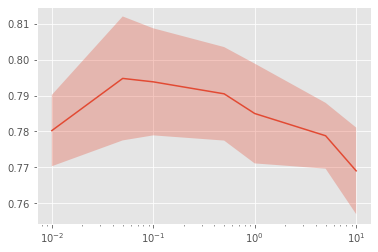

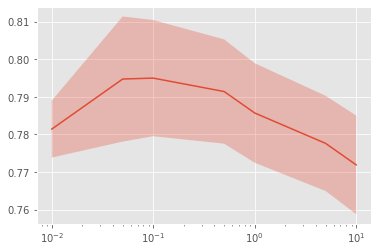

In [76]:

plot_scores(optimizer_zeros)
plot_scores(optimizer_mean)

Получим две метрики качества AUC ROC

In [77]:
#GridSearchCV with zero fillna
print ('Best parameter for GridSearchCV with zero fillna', optimizer_zeros.best_params_)
roc_auc_score_zeros = roc_auc_score(y_test, optimizer_zeros.best_estimator_.predict_proba(X_test_zeros)[:, 1])
print ('roc_auc_score_zeros', roc_auc_score_zeros)
#GridSearchCV with mean fillna
print ('Best parameter for GridSearchCV with mean fillna', optimizer_mean.best_params_)
roc_auc_score_mean = roc_auc_score(y_test, optimizer_mean.best_estimator_.predict_proba(X_test_mean)[:, 1])
print ('roc_auc_score_mean', roc_auc_score_mean)

write_answer_1(roc_auc_score_zeros, roc_auc_score_mean)

Best parameter for GridSearchCV with zero fillna {'C': 0.05}
roc_auc_score_zeros 0.8843724749458951
Best parameter for GridSearchCV with mean fillna {'C': 0.1}
roc_auc_score_mean 0.8879708123853093
0.8861716436656022


## Масштабирование вещественных признаков.

Попробуем как-то улучшить качество классификации. Для этого посмотрим на сами данные:

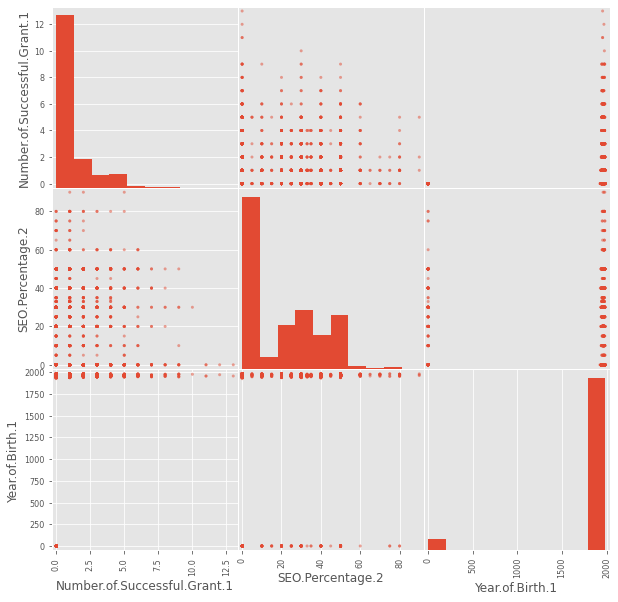

In [78]:
from pandas.plotting import scatter_matrix

data_numeric = pd.DataFrame(X_train_real_zeros, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Как видно из графиков, разные признаки очень сильно отличаются друг от друга по модулю значений (обратите внимание на диапазоны значений осей x и y). В случае обычной регрессии это никак не влияет на качество обучаемой модели, т.к. у меньших по модулю признаков будут большие веса, но при использовании регуляризации, которая штрафует модель за большие веса, регрессия, как правило, начинает работать хуже.

В таких случаях всегда рекомендуется делать стандартизацию (масштабирование) признаков, для того чтобы они меньше отличались друг друга по модулю, но при этом не нарушались никакие другие свойства признакового пространства. При этом даже если итоговое качество модели на тесте уменьшается, это повышает её интерпретабельность, потому что новые веса имеют смысл "значимости" данного признака для итоговой классификации.

Стандартизация осуществляется посредством вычета из каждого признака среднего значения и нормировки на выборочное стандартное отклонение:

$$ x^{scaled}_{id} = \dfrac{x_{id} - \mu_d}{\sigma_d}, \quad \mu_d = \frac{1}{N} \sum_{i=1}^l x_{id}, \quad \sigma_d = \sqrt{\frac{1}{N-1} \sum_{i=1}^l (x_{id} - \mu_d)^2} $$

## Масштабирование вещественных признаков.

По аналогии с вызовом one-hot encoder отмасштабируем вещественные признаки для обучающих и тестовых выборок X_train_real_zeros и X_test_real_zeros, используя класс 

        StandardScaler
   
   и методы 

        StandardScaler.fit_transform(...)
        StandardScaler.transform(...)

In [79]:
from sklearn.preprocessing import StandardScaler

encoder = StandardScaler()

X_train_real_scaled = encoder.fit_transform(X_train_real_zeros)
X_test_real_scaled = encoder.fit_transform(X_test_real_zeros)

## Сравнение признаковых пространств.

Построим такие же графики для преобразованных данных:

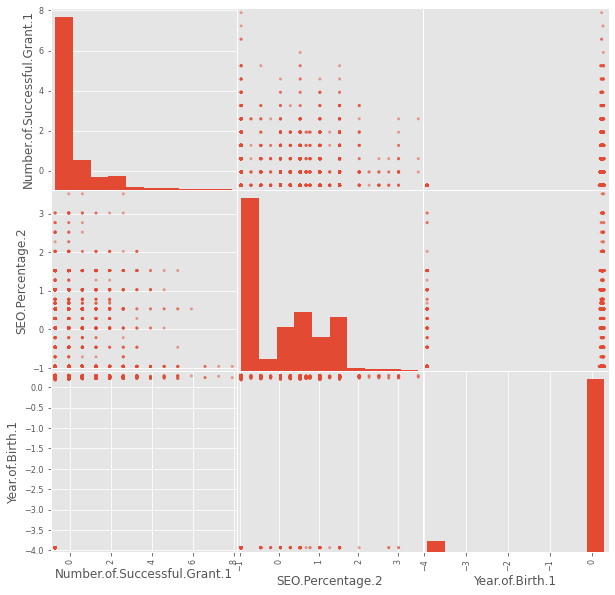

In [80]:
data_numeric_scaled = pd.DataFrame(X_train_real_scaled, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric_scaled[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Как видно из графиков, мы не поменяли свойства признакового пространства: гистограммы распределений значений признаков, как и их scatter-plots, выглядят так же, как и до нормировки, но при этом все значения теперь находятся примерно в одном диапазоне, тем самым повышая интерпретабельность результатов, а также лучше сочетаясь с идеологией регуляризации.

## Сравнение качества классификации до и после масштабирования вещественных признаков.
Обучим ещё раз регрессию и гиперпараметры на новых признаках, объединив их с закодированными категориальными.
Получим значение ROC AUC на тестовой выборке и сравним с лучшим результатом, полученными ранее.

In [81]:
#stacking numerical and categorical features
X_train_scaled = np.hstack( (X_train_real_scaled, X_train_cat_oh) )
X_test_scaled = np.hstack( (X_test_real_scaled, X_test_cat_oh) )

In [84]:
%%time
# GridSearchCV with zero fillna
optimizer_zeros.fit(X_train_scaled, y_train)
print(optimizer_zeros)

GridSearchCV(cv=3, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]})
Wall time: 5.65 s


In [85]:
#GridSearchCV with zero fillna
print ('Best parameter for GridSearchCV with scaled num parameters', optimizer_zeros.best_params_)
roc_auc_score_scaled = roc_auc_score(y_test, optimizer_zeros.best_estimator_.predict_proba(X_test_scaled)[:, 1])
print ('roc_auc_score', roc_auc_score_scaled)


Best parameter for GridSearchCV with scaled num parameters {'C': 0.05}
roc_auc_score 0.8843588636282079
0.8843588636282079


## Балансировка классов.

Посмотрим, сбалансированны ли классы в нашей обучающей выборке:

In [88]:
print(np.sum(y_train==0))
print(np.sum(y_train==1))

2316
1884


Видно, что нет.

Исправить ситуацию можно разными способами:
- давать объектам миноритарного класса больший вес при обучении классификатора
- досэмплировать объекты миноритарного класса, пока число объектов в обоих классах не сравняется

Обучим логистическую регрессию и гиперпараметры с балансировкой классов, используя веса (параметр class_weight='balanced' регрессии) на отмасштабированных выборках, полученных в предыдущем задании. Убедитесь, что вы нашли максимум accuracy по гиперпараметрам.

In [90]:
#GridSearchCV parameters
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3
estimator = LogisticRegression(class_weight='balanced')

In [92]:
%%time
#GridSearchCV with balanced weights
optimizer = GridSearchCV(estimator, param_grid, cv=cv)
optimizer.fit(X_train_scaled, y_train)
print (optimizer)

C:\Users\ryzho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ryzho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=3, estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]})
Wall time: 28.4 s


In [93]:
#GridSearchCV with balanced weights
print ('Best parameter for GridSearchCV with balanced weights', optimizer.best_params_)
roc_auc_score_bal1 = roc_auc_score(y_test, optimizer.best_estimator_.predict_proba(X_test_scaled)[:, 1])
print ('roc_auc_score', roc_auc_score_bal1)

Best parameter for GridSearchCV with balanced weights {'C': 0.1}
roc_auc_score 0.8867507433635545


Сбалансируем выборку, досэмплировав в неё объекты из меньшего класса. 

In [101]:
# generating new indices for class 1

np.random.seed(0)
indices_to_add = np.random.randint((np.sum(y_train==0) - np.sum(y_train==1)), size =(np.sum(y_train==0) - np.sum(y_train==1)) )
X_train_to_add = X_train_scaled[y_train == 1,:][indices_to_add,:]

X_train_added = np.vstack((X_train_scaled, X_train_to_add))

y_train_to_add = np.array([1]*(np.sum(y_train==0) - np.sum(y_train==1)))
y_train_added = np.concatenate((y_train, y_train_to_add), axis= 0)

# new X, y train
X_train_balanced = np.vstack((X_train_scaled, X_train_to_add))
y_train_balanced = np.append(y_train, y_train_to_add)
print(X_train_balanced.shape, X_train_scaled.shape)
print(y_train_balanced.shape, y_train.shape)

(4632, 5606) (4200, 5606)
(4632,) (4200,)


In [104]:
# GridSearchCV with balanced weights
optimizer = GridSearchCV(estimator, param_grid, cv=cv)
optimizer.fit(X_train_scaled, y_train)
print(optimizer)

C:\Users\ryzho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ryzho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=3, estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]})


In [105]:
#GridSearchCV with balanced weights
print ('Best parameter for GridSearchCV with balanced weights', optimizer.best_params_)
roc_auc_score_bal2 = roc_auc_score(y_test, optimizer.best_estimator_.predict_proba(X_test_scaled)[:, 1])
print ('roc_auc_score', roc_auc_score_bal2)

Best parameter for GridSearchCV with balanced weights {'C': 0.1}
roc_auc_score 0.8867507433635545


## Стратификация выборки.

In [108]:
(X_train_real_zeros, 
 X_test_real_zeros, 
 y_train, y_test) = train_test_split(X_real_zeros, y, 
                                     test_size=0.3, 
                                     random_state=0, stratify=y)
print (X_train_real_zeros.shape, X_test_real_zeros.shape, y_train.shape)

(X_train_real_mean, 
 X_test_real_mean, 
 y_train, y_test) = train_test_split(X_real_mean, y, 
                                     test_size=0.3, 
                                     random_state=0, stratify=y)

(X_train_cat_oh,
 X_test_cat_oh) = train_test_split(X_cat_oh, 
                                   test_size=0.3, 
                                   random_state=0, stratify=y)

(4200, 13) (1800, 13) (4200,)


In [109]:
encoder = StandardScaler()

X_train_real_scaled = encoder.fit_transform(X_train_real_zeros)
X_test_real_scaled = encoder.fit_transform(X_test_real_zeros)

#stacking numerical and categorical features
X_train_scaled = np.hstack( (X_train_real_scaled, X_train_cat_oh) )
X_test_scaled = np.hstack( (X_test_real_scaled, X_test_cat_oh) )

In [110]:
#GridSearchCV parameters
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3
estimator = LogisticRegression(class_weight='balanced')

In [112]:
%%time
optimizer = GridSearchCV(estimator, param_grid, cv=cv)
optimizer.fit(X_train_scaled, y_train)
print (optimizer)

C:\Users\ryzho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ryzho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=3, estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]})
Wall time: 28.8 s


C:\Users\ryzho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [113]:
#GridSearchCV
print ('Best parameter for GridSearchCV with balanced weights', optimizer.best_params_)
roc_auc_score_strat = roc_auc_score(y_test, optimizer.best_estimator_.predict_proba(X_test_scaled)[:, 1])
print ('roc_auc_score', roc_auc_score_strat)

Best parameter for GridSearchCV with balanced weights {'C': 0.1}
roc_auc_score 0.879435786823499


## Трансформация признаков.

Теперь рассмотрим способы преобразования признаков. Существует достаточно много различных способов трансформации признаков, которые позволяют при помощи линейных методов получать более сложные разделяющие поверхности. Самым базовым является полиномиальное преобразование признаков. Его идея заключается в том, что помимо самих признаков вы дополнительно включаете набор все полиномы степени $p$, которые можно из них построить. Для случая $p=2$ преобразование выглядит следующим образом:

$$ \phi(x_i) = [x_{i,1}^2, ..., x_{i,D}^2, x_{i,1}x_{i,2}, ..., x_{i,D} x_{i,D-1}, x_{i,1}, ..., x_{i,D}, 1] $$

Рассмотрим принцип работы данных признаков на данных, сэмплированных их гауссиан:

In [115]:
from sklearn.preprocessing import PolynomialFeatures
transform = PolynomialFeatures(2)

data_train_poly = transform.fit_transform(X_train_real_zeros)
data_test_poly = transform.transform(X_test_real_zeros)

encoder = StandardScaler()

data_train_poly_scaled = encoder.fit_transform(data_train_poly)
data_test_poly_scaled = encoder.fit_transform(data_test_poly)

# stacking numerical and categorical features
data_train_poly_full = np.hstack((data_train_poly_scaled, X_train_cat_oh))
data_test_poly_full = np.hstack((data_test_poly_scaled, X_test_cat_oh))

In [116]:
#GridSearchCV parameters
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3
estimator = LogisticRegression(class_weight='balanced', fit_intercept=False)

In [118]:
%%time
optimizer = GridSearchCV(estimator, param_grid, cv=cv)
optimizer.fit(data_train_poly_full, y_train)
print (optimizer)

C:\Users\ryzho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ryzho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          fit_intercept=False),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]})
Wall time: 29.2 s


C:\Users\ryzho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [119]:
#GridSearchCV
print ('Best parameter for GridSearchCV with balanced weights', optimizer.best_params_)
roc_auc_score_poly = roc_auc_score(y_test, optimizer.best_estimator_.predict_proba(data_test_poly_full)[:, 1])
print ('roc_auc_score', roc_auc_score_poly)

Best parameter for GridSearchCV with balanced weights {'C': 0.1}
roc_auc_score 0.887558526015156


## Отбор признаков при помощи регрессии Lasso.
К логистической регрессии также можно применить L1-регуляризацию (Lasso), вместо регуляризации L2, которая будет приводить к отбору признаков.

In [120]:
def write_answer_6(features):
    
    print(" ".join([str(num) for num in features]))

In [121]:
encoder = StandardScaler()

data_train_lasso_scaled = encoder.fit_transform(X_train_real_zeros)
data_test_lasso_scaled = encoder.fit_transform(X_test_real_zeros)

#stacking numerical and categorical features
data_train_lasso_full = np.hstack( (data_train_lasso_scaled, X_train_cat_oh) )
data_test_lasso_full = np.hstack( (data_test_lasso_scaled, X_test_cat_oh) )

In [125]:
#GridSearchCV parameters
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3
estimator = LogisticRegression(class_weight='balanced', fit_intercept=False, penalty='l1', solver='liblinear')

In [126]:
%%time
optimizer = GridSearchCV(estimator, param_grid, cv=cv)
optimizer.fit(data_train_lasso_full, y_train)
print (optimizer)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          fit_intercept=False, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]})
Wall time: 7.08 s


In [127]:
#GridSearchCV
print ('Best parameter for GridSearchCV with balanced weights', optimizer.best_params_)
roc_auc_score_lasso = roc_auc_score(y_test, optimizer.best_estimator_.predict_proba(data_test_lasso_full)[:, 1])
print ('roc_auc_score', roc_auc_score_lasso)

Best parameter for GridSearchCV with balanced weights {'C': 1}
roc_auc_score 0.8768049149413619


In [131]:
print (optimizer.best_estimator_.coef_.ravel())
print (X_train_real_zeros.shape[1])
zero_coefs = [index for index, value in enumerate(optimizer.best_estimator_.coef_[0][:13]) if value == 0]
print ('Features with zero weight', zero_coefs)

[ 0.00873622  0.03987201 -0.08873258 ...  2.09126176  0.
  0.34704291]
13
Features with zero weight [4, 6, 7]
